<a href="https://colab.research.google.com/github/NaimaZouidi/Frenshi-chatbot/blob/main/Frenshi_chatbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Frenshi Chatbot

This notebook trains a chatbot called Frenshi on the administrative formalities in France for foreign students to help them during their stay! It proposes FR and EN versions to help these later regardless of whether they can speak French or not!

# Set-up enviroment
To run this colab you will need to import some python modules such as Tensorflow, pandas, etc. You will also need to install textaugment library to perform text data augmentation in order to improve the model performance. Please click [here](https://github.com/dsfsi/textaugment/tree/master) to learn more about this library and how to use it.



In [1]:
try:
  import textaugment
except ModuleNotFoundError:
  !pip install textaugment

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 7.3 MB/s eta 0:00:00
  Created wheel for googletrans: filename=googletrans-3.0.0-py3-none-any.whl size=15715 sha256=9abaa89d8e416dace715fffbefe43d22b76157f68849637361260c156b4a6ed3
  Stored in directory: /root/.cache/pip/wheels/b3/81/ea/8b030407f8ebfc2f857814e086bb22ca2d4fea1a7be63652ab
Successfully built googletrans
  Attempting uninstall: chardet
    Found existing installation: chardet 5.2.0
    Uninstalling char

In [2]:
import tensorflow as tf
import json
import random
import pandas as pd
import string
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, GlobalAvgPool1D, Flatten, Dropout
from tensorflow.keras.models import Model
from sklearn.preprocessing import LabelEncoder
from textaugment import EDA
from textaugment import Translate

# Help-in functions

This function creates an NLP model with an LSTM transformer.


```
input_shape: is the length of the user's input.
output_len: is the number of output tags or classes.
```



In [3]:
def createFrenshiModel(input_shape, vocabulary, output_len):
  i = Input(shape=(input_shape))
  x = Embedding(vocabulary + 1, 10)(i)
  x = LSTM(10, return_sequences=True)(x)
  x = Flatten()(x)
  x = Dropout(rate=0.2)(x)
  x = Dense(output_len, activation="softmax")(x)
  model = Model(i, x)
  return model

This function will prepare our dataset to convert it to dataframe afterward. Indeed, our chatbot will be trained on a paire of data ```(user's input, class/tag)``` in order to find the best answer to any user's input.


```
dataset: is the original dataset.
```





In [4]:
def prepare_dataset(dataset):
  tags = []
  inputs = []
  responses = {}
  for intent in dataset["intents"]:
    responses[intent["tag"]] = intent["responses"]
    for text in intent["input"]:
      inputs.append(text)
      tags.append(intent["tag"])
  return inputs, tags, responses

This function will apply the RTT-based augmentation technique on our dataset. This later translate texte from one language to another. Then, retranslate it back in order to create new text data.

```
dataset: respresents the original dataset.
```



In [5]:
def augment_data_with_RTTbased_augmentation(inputs, tags):
  translatorFR = Translate(src="fr", to="en")
  translatorEN = Translate(src="en", to="fr")
  inputs_new = []
  tags_new = []
  for i, text in enumerate(inputs):
      inputs_new.append(text)
      tags_new.append(tags[i])
      try:
        if("FR" in tags[i]):
          augmented_text = translatorFR.augment(text) #Select retranslation from French to English if user's input is in French
        else:
          augmented_text = translatorEN.augment(text) #Select retranslation from English to French if user's input is in English
      except AttributeError:
        continue
      print(augmented_text)
      inputs_new.append(augmented_text)
      tags_new.append(tags[i])
  return inputs_new, tags_new

This function will apply random deletion augmentation technique on our dataset, which will randomly remove each word in the user's input with probability ```p```.




```
dataset: respresents the original dataset.
```

In [6]:
def augment_data_with_random_deletion(inputs, tags):
  inputs_new = []
  tags_new = []
  eda = EDA(random_state=1)
  for i, text in enumerate(inputs):
      inputs_new.append(text)
      tags_new.append(tags[i])
      augmented_text = eda.random_deletion(text, p=0.2)
      print(augmented_text)
      inputs_new.append(augmented_text)
      tags_new.append(tags[i])
  return inputs_new, tags_new

This function will apply random swap data augmentation technique on our dataset which will randomly select two words in the user's input and swap their positions. It do this for ```n```times.



```
dataset: is the original dataset
```



In [7]:
def augment_data_with_random_swap(inputs, tags):
  inputs_new = []
  tags_new = []
  eda = EDA(random_state=1)
  for i, text in enumerate(inputs):
      inputs_new.append(text)
      tags_new.append(tags[i])
      augmented_text = eda.random_swap(text)
      print(augmented_text)
      inputs_new.append(augmented_text)
      tags_new.append(tags[i])
  return inputs_new, tags_new

This function gives some training parameters for the chatbot.


```
Tokenizer: is the tokenizer used to tokenize the data.
labelEnc: is the encoder used to encode tags into numeric data.
```



In [8]:
def get_training_parameters(tokenizer, labelEnc):
  vocabulary = len(tokenizer.word_index)
  print("The number of unique words is: ", vocabulary)
  output_len = labelEnc.classes_.shape[0]
  print("The output length is: ", output_len)
  return vocabulary, output_len

This function tokenize the user's input and encode the tag into numeric data to train the chatbot.


```
dataset: is the dataset.
```



In [9]:
def tokenizeAndEncodeData(dataset):
  tokenizer = Tokenizer(num_words=2000);
  tokenizer.fit_on_texts(dataset['inputs']);
  train = tokenizer.texts_to_sequences(dataset['inputs'])
  #Apply padding
  x_train = pad_sequences(train)
  #Encoding output to numeric data
  labelEnc = LabelEncoder()
  y_train = labelEnc.fit_transform(dataset['tags'])
  return tokenizer, labelEnc, x_train, y_train

# Preparing Data set
In order to train Frenshi we need to create a dataset, a json file here, which will hold user's questions and the best answers to it underneath a tag or class such as: `greetingDay FR inputs/answers`, `goodbyeDay FR inputs/answers,` etc. In order to help foreign students regardless of whether they can speak French or not we will create an FR and EN versions of our dataset!


In [36]:
%%writefile datasetFR.json
{"intents":
[
   {
      "tag": "greetingDay FR",
      "input": ["Salut !", "Salut Frenshi", "Bonjour", "Bonjour Frenshi", "Coucou", "Coucou Frenshi !"],
      "responses" : ["Bienvenue ! Je suis Frenshi ! je suis là pour vous aider et accompagner dans vos démarches administratives en France. Les démarches administratives sont souvent un vrai casse-tête, d'autant plus pour les étudiants étrangers arrivant dans un nouveau pays. Mais ne vous inquiétez pas ! Je suis là pour vous ! Pour commencer veuillez choisir parmi les propositions suivantes:\nValider mon visa, titre de séjour, CAF ou sécurité sociale",
      "Bonjour ! Je suis Frenshi ! je suis là pour vous aider et accompagner dans vos démarches administratives en France. Les démarches administratives sont souvent un vrai casse-tête, d'autant plus pour les étudiants étrangers arrivant dans un nouveau pays. Mais ne vous inquiétez pas ! Je suis là pour vous ! Pour commencer veuillez choisir parmi les propositions suivantes:\nValider mon visa, titre de séjour CAF ou sécurité sociale",
      "Oh salut ! Je suis Frenshi ! je suis là pour vous aider et accompagner dans vos démarches administratives en France. Les démarches administratives sont souvent un vrai casse-tête, d'autant plus pour les étudiants étrangers arrivant dans un nouveau pays. Mais ne vous inquiétez pas ! Je suis là pour vous ! Pour commencer veuillez choisir parmi les propositions suivantes:\nValider mon visa, titre de séjour CAF ou sécurité sociale"]
    },
    {
      "tag": "greetingEvening FR",
      "input": ["Bonsoir", "Bonsoir Frenshi!"],
      "responses" : ["Bienvenue ! Je suis Frenshi! je suis là pour vous aider et accompagner dans vos démarches administratives en France. Les démarches administratives sont souvent un vrai casse-tête, d'autant plus pour les étudiants étrangers arrivant dans un nouveau pays. Mais ne vous inquiétez pas ! Je suis là pour vous ! Pour commencer veuillez choisir parmi les propositions suivantes:\nCAF, titre de séjour ou sécurité sociale",
      "Bonsoir ! Je suis Frenshi ! je suis là pour vous aider et accompagner dans vos démarches administratives en France. Les démarches administratives sont souvent un vrai casse-tête, d'autant plus pour les étudiants étrangers arrivant dans un nouveau pays. Mais ne vous inquiétez pas ! Je suis là pour vous ! Pour commencer veuillez choisir parmi les propositions suivantes:\nValider mon visa, titre de séjour CAF ou sécurité sociale",
      "Oh salut ! Je suis Frenshi ! je suis là pour vous aider et accompagner dans vos démarches administratives en France. Les démarches administratives sont souvent un vrai casse-tête, d'autant plus pour les étudiants étrangers arrivant dans un nouveau pays. Mais ne vous inquiétez pas ! Je suis là pour vous ! Pour commencer veuillez choisir parmi les propositions suivantes:\nValider mon visa, titre de séjour CAF ou sécurité sociale"]
    },
    {
      "tag": "goodbyeDay FR",
      "input": ["ça marche!","ça marche! Bonne journée", "ça marche ! Merci", "ça marche ! Au revoir", "ça marche ! Merci beaucoup", "Ca marche!", "Ca marche ! Bonne journée", "Ca marche ! Merci", "Ca marche ! Au revoir", "Ca marche ! Merci beaucoup", "Top !", "Top ! Bonne journée", "Top ! Merci", "Top ! Merci beaucoup", "Top ! Au revoir", "D'accord", "D'accord ! Au revoir !", "D'accord! Merci !", "D'accord ! Merci beaucoup", "D'accord ! Bonne journée", "Super !", "Super ! Merci !", "Super ! merci beaucoup", "Super ! Au revoir", "Super ! bonne journée", "Au revoir !", "Au revoir Frenshi !", "Merci beaucoup ! Au revoir", "Merci beaucoup ! Au revoir Frenshi", "Oh ! Merci beaucoup", "Oh ! Merci beaucoup Frenshi", "Merci beaucoup ! Bonne journée", "Merci beaucoup ! Bonne journée Frenshi", "Merci !", "Merci Frenshi !", "Bonne journée", "Bonne journée Frenshi !"],
      "responses" : ["Au revoir ! N'hésitez pas à revenir vers moi si vous avez d'autres questions concernant vos démarches administratives en France !",
      "Je t'en prie ! N'hésitez pas à me poser d'autres question si vous avez besoin d'aide ou d'assistance dans vos démarches administratives en France ! A plus.",
      "Bonne journée ! N'hésitez pas à revenir vers moi si vous avez d'autres questions concernant vos démarches administratives en France !"]
    },
    {
      "tag": "goodbyeEvening FR",
      "input": ["Bonne nuit", "Bonne soirée", "D'accord ! Bonne soirée", "D'accord ! Bonne nuit", "Super ! Bonne soirée", "Ca marche ! Bonne soirée", "ça marche ! Bonne soirée", "ça marche ! Bonne nuit", "Ca marche ! Bonne nuit", "Top ! Bonne soirée", "Top ! Bonne nuit", "Merci beaucoup ! Bonne soirée", "Merci beaucoup ! Bonne soirée Frenshi !", "Merci beaucoup ! Bonne nuit", "Merci beaucoup ! Bonne nuit Frenshi", "Merci ! Bonne soirée", "Merci ! Bonne soirée Frenshi !", "Merci ! Bonne nuit", "Merci ! Bonne nuit Frenshi", "Bonne soirée Frenshi !", "Bonne nuit Frenshi !"],
      "responses" : ["Au revoir ! N'hésitez pas à revenir vers moi si vous avez d'autres questions concernant vos démarches administratives en France!",
      "Je t'en prie ! N'hésitez pas à me poser d'autres question si vous avez besoin d'aide ou d'assistance dans vos démarches administratives en France!",
      "Bonne nuit ! N'hésitez pas à revenir vers moi si vous avez d'autres questions concernant vos démarches administratives en France !",
      "Bonne soirée ! N'hésitez pas à revenir vers moi si vous avez d'autres questions concernant vos démarches administratives en France !"]
    },
    {
      "tag": "Validate visa FR",
      "input": ["Comment valider mon visa", "Où valider mon visa", "Valider mon visa", "Validation visa", "Savoir plus sur la validation de visa", "Je souhaite valider mon visa"],
      "responses":["Dés votre arrivée en France et au plus tard dans les 3 mois suivant votre arrivée, vous devez valider votre visa pour lui donner une Valeur de Titre de Séjour (VTS). Cette procédure est obligatoire pour tous les détenteurs d'une visa.\nVous devez valider votre visa en ligne sur le site internet de l'ANEF ci-dessous :\n\nhttps://administration-etrangers-en-France.interieur.gouv.fr/particuliers/#/\nSur ce site vous allez saisir le numéro de votre visa, quelques informations personnelles et payé une taxe de 50€ pour un 'statut étudiant' sous forme d'un timbre fiscal électronique, afin de recevez une attestation de validation au format PDF.",
      "Vous devez valider votre visa dès votre arrivée en France et au plus tard dans les 3 mois suivant votre arrivée afin de lui donner une Valeur de Titre de Séjour (VTS). Tous les titulaires d'une visa doivent effectuer cette procédure. \nPar consequent, vous pouvez faire en ligne sur le site internet de l'ANEF ci-dessous:\n\nhttps://administration-etrangers-en-France.interieur.gouv.fr/particuliers/#/,\nSur ce site, vous allez entrer le numéro de votre visa, quelques informations personnelles et payer une taxe de 50€ pour un 'statut étudiant' sous forme d'un timbre fiscal électronique afin de recevoir une attestation de validation au format PDF.",
      "Pour lui donner une Valeur de Titre de Séjour (VTS), vous devez valider votre visa dès votre arrivée en France et au plus tard dans les 3 mois suivant votre arrivée. Tous ceux qui ont un visa doivent effectuer cette procédure en ligne.\nPar consequent, vous pouvez faire sur le site internet de l'ANEF :https://administration-etrangers-en-France.interieur.gouv.fr/particuliers/#/\nSur ce site, vous devez saisir le numéro de votre visa, quelques informations personnelles et payer une taxe de 50€ pour un 'statut étudiant' sous forme de timbre fiscal électronique afin de recevoir une attestation de validation au format PDF."]
    },
    {
      "tag": "Civil state FR",
      "input": ["Justificatif état civil", "état civil", "Etat civil", "C'est quoi l'état civil?", "Quel document pour l'état civil?", "Quelle pièce justificative pour l'état civil?", "savoir plus sur l'état civil", "Je souhaite savoir plus sur l'état civil?", " Quel justificatif pour l’état civil"],
      "responses":["La pièce justificative à fournir pour l'état civil peut dépendre de démarche administratif à faire, à savoir: une démarche pour un titre de séjour ou la sécurité sociale. Veuillez s'il vous plait préciser cela dans votre question. Merci !",
      "Le document à fournir pour l'état civil peut varier en fonction de la démarche administratif à faire, telle qu'une demande de titre de séjour ou de sécurité sociale. Veuillez s'il vous plait préciser cela dans votre question. Merci !"]
    },
    {
      "tag": "Resident permit FR",
      "input":["Titre de séjour", "Que ce que c'est un titre de séjour?", "Pourquoi un titre de séjour?", "Quel titre de séjour faut-t-il demander?", "Quel titre de séjour pour un étudiant étranger?", "Quel titre de séjour pour une étudiante étrangere?", "Dois-je demande un titre de séjour?", "Savoir plus sur le titre de séjour", "Je souhaite savoir plus sur le titre de séjour"],
      "responses": ["Le titre de séjour est un document qui vous permet de circuler et franchir les frontières de l'espace Schengen. En tant qu'étudiant étranger vous devez demander un titre de séjour mention étudiant ou chercheur si vous êtes venu faire une thèse de doctorat.",
      "En France, le titre de séjour vous permet de circuler et franchir les frontières de l'espace Schengen. En tant qu'étudiant étranger vous devez demander un titre de séjour mention étudiant ou chercheur si vous êtes venu faire une thèse de doctorat.",
      "Le titre de séjour en France justifie vos droits et vous permet de circuler et franchir les frontières de l'espace Schengen. En tant qu'étudiant étranger vous devez demander un titre de séjour mention étudiant ou chercheur si vous êtes venu faire une thèse de doctorat."]
    },
    {
      "tag":"Hosting agreement FR",
      "input":["Convention d'accueil", "Pourquoi une convention d'accueil?", "C'est quoi une convention d'accueil?", "Je souhaite savoir plus sur la convention d'accueil", "Savoir plus sur la convention d'accueil"],
      "responses":["Afin que vous puissiez demander un titre de séjour mention 'chercheur', votre laboratoire d'accueil vous fera parvenir une convention d'accueil  signée par le responsable de l'organisme d'accueil et cachetée par l'établissement.\nAttention : Seuls les établissements d'enseignement supérieur et certains organismes agréés peuvent émettre une convention d'accueil.",
      "Pour demander un titre de séjour mention 'chercheur', votre laboratoire d'accueil doit vous adresser une convention d'accueil signée par le responsable de l'organisme d'accueil et cachetée par l'établissement.\n Attention : seuls les établissements d'enseignement supérieur et certains organismes agréés peuvent délivrer une convention d'accueil.",
      "Pour ta demande de titre de séjour mention 'chercheur', il est essentiel que votre laboratoire d'accueil vous addresse une convention d'accueil signée par le responsable de l'organisme d'accueil et cachetée par l'établissement.\nAttention : Seuls les établissements d'enseignement supérieur et certains organismes agréés sont autorisés à établir une convention d'accueil."]
    },
    {
      "tag": "Documents for Resident permit FR",
      "input": ["Justificatifs titre de séjour", "Quelles sont les pièces justificatives pour demander un titre de séjour?", "Comment formuler ma demande de titre de séjour?", "Pièces justificatives titre de séjour", " Savoir plus sur les pièces justificatives pour demander un titre de séjour", "Je souhaite savoir plus sur les pièces justificatives pour formuler ma demande de titre de séjour"],
      "responses": ["Voici la liste des pièces justificatives que vous aurez besoin pour préparer de votre demande de titre de séjour:\n1. Un justificatif d'état civil.\n2. Photographie d'identité récente datant de moins de 3 mois.\n3. Justificatifs de domicile datant d'au moins de 6 mois.\n4. Le motif de votre séjour.\n5. Des ressources financières.",
      "Quant aux pièces justificatives que vous aurez besoin pour préparer votre demande de titre de séjour, ils sont les suivantes:\n1. Un justificatif d'état civil.\n2. Photographie d'identité récente datant de moins de 3 mois.\n3. Justificatifs de domicile datant d'au moins de 6 mois.\n4. Le motif de votre séjour.\n5. Des ressources financières.",
      "Pour formuler votre demande de titre de séjour de titre de séjour ous aurez besoin des pièces justificatives suivantes:\n1. Etat civil.\n2. Photographie d'identité récente datant de moins de 3 mois.\n3. Justificatifs de domicile datant d'au moins de 6 mois.\n4. Le motif de votre séjour.\n5. Des ressources financières."]
    },
    {
      "tag": "Civil state resident permit FR",
      "input": ["Justificatif état civil titre de séjour", "Etat civil titre de séjour", "état civil titre de séjour", "Je souhaite savoir quel justificatif d'état civil dont j'ai besoin pour ma demande de titre de séjour?", "Qu’est-ce que le justificatif de l'état civil pour une demande de titre de séjour?", "Quel est le document d'état civil à fournir pour ma demande de titre de séjour", "Peux-je joindre quoi comme document pour l'état civil dans ma demande de titre de séjour?"],
      "responses": ["Pour l'état civil il vaut faut un titre de séjour en cours de validité, s'il s'agit d'un renouvellement, ou juste votre passeport. En effet, si vous n'avez pas de titre de séjour en cours de validité, veuillez joindre les pages de votre passeport relatives à l'état civil, aux dates de validité, aux cachets d'entrée et aux visas y a compris ton visa long séjour VTS.",
      "Quant à l'état civil il vaut faut un titre de séjour en cours de validité, s'il s'agit d'un renouvellement, ou juste votre passeport. En effet, si vous n'avez pas de titre de séjour en cours de validité, veuillez joindre les pages de votre passeport relatives à l'état civil, aux dates de validité, aux cachets d'entrée et aux visas y a compris ton visa long séjour VTS."]
    },
    {
      "tag": "Identity photograph FR",
      "input": ["Quelle photographie d'identité?", "Photographie d'identité", "Format de photographie d'identité", "Quelle format pour la photographie d'identité", "Photo d'identité", "Quelle photo d'identité?", "Format de photo d'identité", "Quelle format pour le photo d'identité?"],
      "responses":["La photographie d'identité prend la forme une e-photo datant de moins de 6 mois.",
      "La photographie d'identité prend la forme d'une e-photo et doit avoir été prise il y a moins de 6 mois."]
    },
    {
      "tag": "E-photo FR",
      "input": ["C'est quoi un e-photo?", "e-photo", "Savoir plus sur l'e-photo", "Je souhaite savoir plus sur l'e-photo"],
      "responses": ["L'e-photo est une photo d'identité dématérialisée avec une signature numérique.",
      "L'e-photo présente une photo d'identité dématérialisée avec une signature numérique."]
    },
    {
      "tag": "Reason for staying FR",
      "input": ["Quels sont les documents pour le motif de mon séjour?", "Je souhaite savoir plus sur les documents à fournir pour le motif de mon séjour?", "Motif de séjour", "Savoir plus sur le motif de titre de séjour", "Je souhaite savoir plus sur le motif de séjour", "C'est quoi le motif de séjour?", "Motif de séjour étudiant", "Quels sont les documents à fournir pour le motif de séjour?", "Quelles sont les pièces justificatives à fournir pour le motif de séjour?", "Peux-je joindre quoi comme pièces justificatives pour le motif de séjour?", "Quels est les document pour le titre de séjour ?"],
      "responses": ["Concernant le motif de votre séjour, il faut fournir une certificat d'inscription ou justificatif de réinscription auprès de votre établissement d'enseignement supérieur.\nVous aurez aussi besoin de:\n1- Vos relevés de notes.\n2- Votre dernier diplôme obtenu.\n3- Une attestation de réussite s'il s'agit d'une renouvellement.\nSi la mention de titre de séjour qui vous solliciter est chercheur vous devez joindre également une convention d'accueil de laboratoire de recherche dont laquelle vous allez effectuer votre thèse de doctorat.",
      "Pour le motif de votre séjour il s'agit de fournir une certificat d'inscription ou justificatif de réinscription auprès de votre établissement d'enseignement supérieur.\nVous aurez aussi besoin de:\n1- Vos relevés de notes.\n2- Votre dernier diplôme obtenu.\n3- Une attestation de réussite s'il s'agit d'une renouvellement.\nSi la mention de titre de séjour qui vous solliciter est chercheur vous devez joindre également une convention d'accueil de laboratoire de recherche dont laquelle vous allez effectuer votre thèse de doctorat."]
    },
    {
      "tag":"Apply for resident permit FR",
      "input": ["Je souhaite demander un titre de séjour", "Comment demander un titre de séjour?" , "Demander un titre de séjour", "Où déposer ma demande de titre de séjour?", "Comment solliciter un titre de séjour?", "Je sollicite un titre de séjour", "Où effectuer ma démarche de titre de séjour?", "Je souhaite effectuer ma démarche de titre de séjour", "Où demander un titre de séjour?"],
      "responses": ["Si vous souhaitez effectuer votre démarche de titre de séjour vous pouvez précéder à travers le site internet de l'ANEF ci-dessous:\nhttps://administration-etrangers-en-France.interieur.gouv.fr/particuliers/#/",
      "Pour effectuer votre démarche de titre de séjour vous pouvez précéder à travers le site internet de l'ANEF ci-dessous:\nhttps://administration-etrangers-en-France.interieur.gouv.fr/particuliers/#/",
      "Pour demander un titre de séjour vous pouvez précéder à travers le site internet de l'ANEF ci-dessous:\nhttps://administration-etrangers-en-France.interieur.gouv.fr/particuliers/#/"]
    },
    {
      "tag": "Proof of address FR",
      "input": ["Quel justificatif pour le domicile?", "Le Justificatif de domicile, c'est quoi?", "Justificatif de domicile", "Peux-je joindre quoi comme justificatif de domicile?", "Je souhaite savoir plus sur le justificatif de domicile", "Savoir plus sur le justificatif de domicile"],
      "responses": ["Le justificatif de domicile peut prendre plusieurs formes. Veuillez s'il vous plait me préciser si vous êtes locataire, héberger à l’hôtel ou chez un particulier. Merci !",
      "Pour le justificatif de domicile, il peut prendre plusieurs formes. Veuillez s'il vous plait me préciser si vous êtes locataire, héberger à l’hôtel ou chez un particulier. Merci !"]
    },
    {
      "tag": "A student renting a flat FR",
      "input": ["Je suis locataire!", "locataire", "Je suis étudiant locataire", "Je suis étudiante locataire", "Etudiant locataire", "étudiant locataire", "Je suis en location", "J'habite en location", "Oui! je suis locataire", "Oui! je suis étudiant locataire", "Oui! Je suis en location", "Oui ! J’habite en location"],
      "responses":["Si vous êtes locataire, vous pouvez joindre un des justificatifs de domicile suivant:\n- Une facture d'électricité, gaz, eau, internet, fixe ou mobile. \n- Une copie du bail de location.\n- Une copie d'une quittance de loyer ou de taxe d'habitation.",
      "Dans le cas où vous êtes locataire il faut joindre un des justificatifs de domicile suivant:\n- Une facture d'électricité, gaz, eau, internet, fixe ou mobile. \n- Une copie du bail de location.\n- Une copie d'une quittance de loyer ou de taxe d'habitation."]
    },
    {
      "tag": "Student staying at a hotel FR",
      "input": ["Je suis hébergé à l’hôtel", "Je suis hébergée à l’hôtel", "Je suis à l’hôtel", "J'habite à l’hôtel", "Oui ! Je suis hébergé à l’hôtel", "Oui ! Je suis hébergée à l’hôtel", "Oui ! Je suis à l’hôtel", "Oui ! J'habite à l’hôtel"],
      "responses":["Si vous êtes hébergé(e) à l'hôtel, vous pouvez joindre un des justificatifs de domicile suivant:\n - Une attestation de l’hôtel.\n- Une copie de votre facture du dernier mois.",
      "Dans le cas où vous êtes hébergé(e) à l’hôtel, vous pouvez joindre un des justificatifs de domicile suivant:\n - Une attestation de l’hôtel.\n- Une copie de votre facture du dernier mois."]
    },
    {
      "tag":"Student staying with family or relatives FR",
      "input":["Je suis chez un particulier", "Je suis hébergé chez un particulier", "Oui! Je suis chez un particulier", "Oui ! Je suis hébergé chez un particulier", "Je suis chez un proche", "Je suis hébergé chez un proche", "Oui ! Je suis chez un proche", "Oui ! Je suis hébergé chez un proche", "Oui ! J'habite chez un proche", "Je suis chez un ami", "J'habite chez un ami", "Oui ! Je suis chez un ami", "Oui ! J'habite chez un ami", "Je suis chez une amie", "Je suis hébergé chez un amie", "Oui ! Je suis chez une amie", "Oui ! Je suis hébergé chez une amie", "Je suis hébergée chez un particulier", "Je suis logée chez un particulier", "Oui ! Je suis hébergée chez un particulier", "Oui ! Je suis logée chez un particulier", "Je suis hébergée chez un proche", "Je suis logée chez un proche", "Oui ! Je suis hébergée chez un proche", "Je suis hébergée chez un ami", "Je suis logée chez un ami", "Oui ! Je suis hébergée chez un ami", "Oui ! Je suis logée chez une ami", "Je suis hébergée chez une amie", "Je suis logée chez une amie", "Oui ! Je suis hébergée chez un amie"],
      "responses":["Si vous êtes hébergé(e) chez un particulier, vous pouvez joindre un des justificatifs de domicile suivant:\n- Une attestation de l'hébergeant datée et signée.\n- Une copie de sa Carte d'Identité Nationale(CIN) ou de sa carte de séjour.\n- Un justificatif de domicile de l'hébergeant si l'adresse inscrite sur son CIN n'est pas à jour.",
      "Dans le cas où vous êtes hébergé(e) chez un particulier, vous pouvez joindre un des justificatifs de domicile suivant:\n- Une attestation de l'hébergeant datée et signée.\n- Une copie de sa Carte d'Identité Nationale (CIN) ou de sa carte de séjour.\n- Un justificatif de domicile de l'hébergeant si l'adresse inscrite sur son CIN n'est pas à jour."]
    },
    {
      "tag": "Supporting documents Financial ressources FR",
      "input": ["Quels sont les justificatifs pour les ressources financières?", "Justificatifs Ressources financiers", "Ressources financières", "Quels sont les documents dont j’ai besoin pour les ressources financières", "Quelles pièces justificatives pour les ressources financières?", "Pièces justificatives ressources financières", "Savoir plus sur les justificatifs pour les ressources financières", "Je souhaite savoir plus sur les pièces justificatives pour les ressources financières"],
      "responses": ["Les justificatifs des ressources financiers peut dépendre de votre situation. Veuillez s'il vous plait me préciser si vous êtes pris en charge par un tiers, boursier, salarié ou vous avez des ressources financières suffisantes pour vos études.",
      "En ce que concerne les justificatifs des ressources financiers ceux-ci peut dépendre de votre situation. Veuillez s'il vous plait me préciser si vous êtes pris en charge par un tiers, boursier, salarié ou vous avez des ressources financières suffisantes pour vos études.",
      "Pour les justificatifs des ressources financiers cela peut dépendre de votre situation. Veuillez s'il vous plait me préciser si vous êtes pris en charge par un tiers, boursier, salarié ou vous avez des ressources financières suffisantes pour vos études."]
    },
    {
      "tag": "Student holding a scholarship FR",
      "input": ["Je suis boursier", "Je suis étudiant boursier", "Boursier", "Étudiant boursier", "J'ai un bourse", "Je bénéficier d'un bourse", "Titulaire d'un bourse", "Oui! Je suis boursier", "Oui ! Je suis étudiant boursier", "Oui ! J'ai un bourse", "Oui ! Je bénéficier d'un bourse", "Oui! Je suis titulaire d'un bourse", "Je suis boursiere", "Je suis étudiante boursiere", "Boursiere", "Étudiant boursiere", "Oui! Je suis boursiere", "Oui ! Je suis étudiante boursiere"],
      "responses": ["Si vous êtes boursier(e), vous pouvez joindre une attestation justificative selon votre situation. Si vous êtes boursier dans votre pays d'origine vous aurez besoin d'une attestation de bourse de l'organisme payeur du pays d'origine. Sinon, vous devez fournir une attestation de financement de gouvernement française ou programme européen qui finance vos études.",
      "Dans le cas où si vous êtes boursier(e), vous pouvez joindre une attestation justificative selon votre situation. Si vous êtes boursier dans votre pays d'origine vous aurez besoin d'une attestation de bourse de l'organisme payeur du pays d'origine. Sinon, vous devez fournir une attestation de financement de gouvernement française ou programme européen qui finance vos études.",
      "Etant donnée que vous êtes boursier(e), vous pouvez joindre une attestation justificative selon votre situation. Si vous êtes boursier dans votre pays d'origine vous aurez besoin d'une attestation de bourse de l'organisme payeur du pays d'origine. Sinon, vous devez fournir une attestation de financement de gouvernement française ou programme européen qui finance vos études."]
    },
    {
      "tag": "Student cared for by a third party FR",
      "input" : ["Je suis pris en charge par un tiers", "pris en charge par un tiers", "Étudiant pris en charge par un tiers", "Je suis pris en charge par mes parents", "Mes parents prennent en charge les frais de mes études", "Je suis pris en charge par un proche", "Un de mes proches prend en charge les frais de mes études", "Je suis prise en charge par un tiers", "prise en charge par un tiers", "Étudiante prise en charge par un tiers", "Je suis prise en charge par mes parents", "Je suis prise en charge par un proche", "Oui ! Je suis pris en charge par un tiers", "Oui ! Je suis prise en charge par mes parents"],
      "responses": ["Si vous êtes pris(e) en charge par un tiers, vous pouvez joindre les attestations suivantes:\n- Une attestation de la banque du tiers justifiant de la programmation de virements réguliers vers votre compte.\n- Une attestation sur l'honneur de versement des sommes permettant d'atteindre le montant requis de 615€/mois à joindre avec un justificatif d'identité du tiers.",
      "Dans le cas où vous êtes pris(e) en charge par un tiers, vous pouvez joindre les attestations suivantes:\n- Une attestation de la banque du tiers justifiant de la programmation de virements réguliers vers votre compte.\n- Une attestation sur l'honneur de versement des sommes permettant d'atteindre le montant requis de 615€/mois à joindre avec un justificatif d'identité du tiers.",
      "Etant donnée que vous êtes pris(e) en charge par un tiers, vous pouvez joindre les attestations suivantes:\n- Une attestation de la banque du tiers justifiant de la programmation de virements réguliers vers votre compte.\n- Une attestation sur l'honneur de versement des sommes permettant d'atteindre le montant requis de 615€/mois à joindre avec un justificatif d'identité du tiers."]
    },
    {
      "tag": "Employee FR",
      "input": ["Je suis salarié", "Je suis étudiant salarié", "Étudiant salarié", "Salarié", "Je travail", "J'ai un job étudiant", "Oui! je suis salarié", "Oui! je suis étudiant salarié", "Je travail", "Oui! Je travail", "Oui! j'ai un job étudiant", "Je suis salariée", "Je suis étudiant salariée", "Étudiante salariée", "Salariée", "Oui! je suis salariée", "Oui! je suis étudiante salariée"],
      "responses": ["Si vous êtes salarié(e), vous pouvez fournir vos trois derniéres fiches de paie.",
      "Dans le cas où vous êtes salarié(e), vous pouvez fournir vos trois derniéres fiches de paie.",
      "Etant donnée que vous êtes salarié(e), vous pouvez fournir vos trois derniéres fiches de paie."]
    },
    {
      "tag": "Student with sufficient financial ressources FR",
      "input": ["J'ai des ressources financières suffisantes!", "ressources financières suffisantes", "Je dispose de ressources financières suffisantes", "Oui! J'ai des ressources financières suffisantes", "Oui! Je dispose de ressources financières suffisantes", "J'ai des ressources suffisantes", "Oui ! j'ai des ressources suffisantes"],
      "responses": ["Si vous disposez des ressources financières suffisantes vous devez fournir l'attestation bancaire de solde créditeur suffisant.",
      "Dans le cas où vous disposez des ressources financières suffisantes vous devez fournir l'attestation bancaire de solde créditeur suffisant.",
      "Etant donnée que vous disposez des ressources financières suffisantes vous devez fournir l'attestation bancaire de solde créditeur suffisant."]
    },
    {
      "tag": "CAF FR",
      "input":["Je souhaite savoir plus sur la CAF", "CAF", "C'est quoi la CAF?", "Aide au logement", "Aide au logement étudiant étranger", "Aide au logement étudiante étrangère", "Quelle aide au logement pour un étudiant étranger?", "Savoir plus sur la CAF", "Je souhaite savoir plus sur l'aide au logement"],
      "responses": ["Les étudiants étrangers en France peuvent avoir des difficultés à louer un logement, particulièrement sur Paris ou les grandes villes universitaires. La Caisse d'Allocations Familiales (CAF) est un organisme français de droit privés, présent dans chaque département française qui verse certaines prestations destinées à lutter contre la pauvreté tel que le RSA ou la Prime d'activité, mais également des aides au logement tel que l'APL.",
      "Comme tous les étudiant français, les étudiants étrangers en France peuvent avoir des difficultés à louer un logement, particulièrement sur Paris ou les grandes villes universitaires. La Caisse d'Allocations Familiales (CAF) est un organisme français de droit privés, présent dans chaque département français qui verse certaines prestations destinées à lutter contre la pauvreté tel que le RSA ou la Prime d'activité, mais également des aides au logement tel que l'APL.",
      "Les étudiants étrangers en France peuvent rencontrer des difficultés pour trouver un logement, en particulier dans les grandes villes universitaires comme Paris. La CAF est une organisation de droit privé située dans chaque département français et offre des prestations pour lutter contre la pauvreté telles que le RSA ou la Prime d'activité, ainsi que des aides au logement telles que l'APL."]
    },
    {
      "tag": "APL FR",
      "input": ["Je souhaite savoir plus sur l'APL", "APL", "C'est quoi l'APL?", "Peux-je demande l'APL?", "Peux-je bénéficie de l'APL", "Aide personnalisée au logement", "Prestation CAF étudiant étranger", "Quelle prestation CAF pour les étudiants étrangers?", "Savoir plus sur l'APL", "Savoir plus sur l'aide personnalisée au logement"],
      "responses": ["L'APL n'est pas spécifiquement destinée aux étudiants, elle s'adresse à toutes personnes ayant de faibles revenus. La bonne nouvelle c'est que même si vous êtes étudiant étranger vous pouvez prétendre à l'APL, cette aide peut faire toute la différence ! Toutefois, vous devez vous acquitter de certaines conditions obligatoires.",
      "L'APL s'adresse à toutes les personnes ayant de faibles revenus et n'est pas spécifiquement destinée aux étudiants. La bonne nouvelle c'est que vous pouvez demander l'APL même si vous êtes étudiant étranger, ce qui peut faire toute la différence ! Mais vous devez respecter certaines conditions.",
      "L'APL n'est pas spécifiquement destinée aux étudiants et s'adresse à toutes les personnes ayant de faibles revenus. La bonne nouvelle, c'est que même si vous êtes étudiant étranger, vous pouvez demander APL, ce qui peut faire toute la différence ! Cependant, il est nécessaire de respecter certaines conditions."]
    },
    {
      "tag": "Apply to APL FR",
      "input": ["Où déposer ma demande d'APL?", "Comment faire une demande d'APL?", "Demande APL", "Demander l'APL", "Démarche APL", "Formuler ma demande d'APL", "Comment formuler ma demande d'APL?", "Comment effectuer ma démarche d'APL?", "Je souhaite faire une demande d'APL", "Je sollicite un APL", "Où faire ma demande d'APL?"],
      "responses": ["Les étudiants étrangers, comme les étudiants français doivent formuler leur demande en ligne sur le site internet de la caf ci-dessous:\nhttps://wwwd.caf.fr/wps/portal/caffr/aidesetdemarches/mesdemarches/faireunedemandedeprestation#DAL\n\nEn remplissant votre demande vous devez préciser que vous n'êtes pas allocataire, en effet, comme c'est votre première demande vous ne possédez pas d'espace personnel sur le site de la CAF. Donc il faut que vous créiez un nouveau compte. Une fois que cela est fait vous pourrez vous connecter à votre compte CAF en ligne.",
      "Les étudiants étrangers, tout comme les étudiants français, doivent remplir leur demande en ligne sur le site internet de la Caf en suivant les instructions suivantes:\nRendez-vous sur le site Web suivant:\nhttps://wwwd.caf.fr/wps/portal/caffr/aidesetdemarches/mesdemarches/faireunedemandedeprestation#DALVous\npuis indiquer dans votre demande que vous n'êtes pas allocataire. Vue que c'est votre première demande et donc vous n'avez pas d'espace personnel sur le site internet de la CAF. Par conséquent, vous devez créer un nouveau compte. Une fois terminé, vous pourrez accéder à votre compte CAF en ligne."]
    },
    {
      "tag": "APL requirements FR",
      "input": ["Comment prétendre à l'APL?", "Conditions d'attribution d'APL", "Conditions d'APL", "Suis-je éligible à l'APL", "Est ce que je suis éligible à l'APL?", "Quelles sont les conditions d'attribution de l'APL?", "Quelles sont les conditions d'APL?", "Je souhaite savoir plus sur les conditions de l'APL", "Savoir plus sur les conditions d'attribution de l'APL?"],
      "responses": ["Pour prétendre de l'APL il faut: \n- Habiter 8 mois minimum dans votre logement étudiant au cours de l'année. \n- Votre logement fait l'objet d'une convention par l'état comme les cités universitaires, les foyers HLM, les logements sociaux, etc.\nAttention : Si vos parents vivent également en France et perçoivent des allocations familiales ces derniers peuvent se voir retirer cette prestation si vous faites une demande d'APL. La règle est la même pour les ressortissants français. De plus si vous habitez en colocation et que vous faites une demande d'APL, votre colocataire se verra dans l'obligatoire d'en faire également, s'il ne fait pas la demande d'APL cela peut impacter votre éligibilité.",
      "Pour être éligible l'APL, il faut que vous habitiez au moins 8 mois dans votre logement étudiant au cours de l'année et que votre logement fait l'objet d'une convention gouvernementale telle que les cités universitaires, les foyers HLM, les logements sociaux, etc. Si vos parents résident également en France et reçoivent des allocations familiales, il est possible que cette prestation leur soit retirée si vous demandez une APL. Les citoyens français sont soumis à la même réglementation. De plus, si vous habitez en colocation et faites une demande d'APL, votre colocataire doit également en faire, sinon cela peut affecter votre éligibilité."]
    },
    {
      "tag": "APL calculation FR",
      "input": ["Je souhaite faire une simulation de mes droits d'APL", "Je souhaite faire une simulation de mes prestations d'APL", "Comment-a-t-il calculé l'APL?", "Calcul d'APL", "Montant d'APL", "Simulation d'APL", "Calcul d'APL", "Quel montant d'APL?", "Savoir plus sur le montant de l'APL"],
      "responses": ["L'APL est calculée en fonction du montant du loyer, de vos ressources (revenus des parents, vos revenus, prestations familiales), son attribution n'est donc pas automatique, et son montant peut dépendre de votre situation. Pour simuler le montant d'aide APL, veuillez s'il vous plait consulter les site internet suivant:\nhttps://wwwd.caf.fr/wps/portal/caffr/aidesetdemarches/mesdemarches/faireunesimulation/lelogement#/preparation",
      "L'attribution de l'APL n'est pas automatique et peut dépendre de votre situation. En effet, le montant de l'APL peut varier en fonction du montant du loyer, de vos ressources (revenus des parents, vos revenus, prestations familiales). Pour faire une simulation de montant de votre aide d'APL, veuillez s'il vous consulter les site internet suivant:\nhttps://wwwd.caf.fr/wps/portal/caffr/aidesetdemarches/mesdemarches/faireunesimulation/lelogement#/preparation"]
    },
    {
      "tag": "Supporting documents APL FR",
      "input":["Je souhaite savoir plus sur les pièces justificatives pour demander l'APL", "Je souhaite savoir plus sur les documents nécessaires pour formuler ma demande d'APL", "Pièces justificatives APL", "Quelles sont les pièces justificatives pour demander l'APL?", "Savoir plus sur les Pièces justificatives pour demander l'APL"],
      "responses": ["Pour formuler votre demande d'APL vous devez obligatoirement avoir un compte bancaire français et donc fournir un RIB. Il vous faut également:\n1. Votre contrat de bail.\n2. Une attestation de domicile, remplie par le propriétaire du logement.\n3. Un justificatif de vos revenus sur les deux dernières années, vous pouvez fournir les déclarations de revenus de ces deux dernières années de votre pays d'origine.\n4. Votre carte d'identité nationale ou passeport, ainsi que votre extrait d'acte de naissance avec une traduction certifiée en français.\n\nSi vous êtes citoyen de l'UE vous devrez fournir une attestation d'inscription à l'université et votre carte d'assurance Européenne d'assurance maladie.\nSi vous êtes non-européen vous devrez joindre un titre de séjour qui soit valide au minimum pour toute l'année universitaire en cours ainsi qu'un justificatif d'inscription au régime de la sécurité sociale étudiante Ameli.",
      "Pour faire une demande d'APL, vous devez avoir un compte bancaire en France et fournir un RIB. De plus, vous devez fournir:\n1. Votre contrat de bail.\n2. Une attestation de domicile remplie par le propriétaire du logement.\n3. Pour justifier vos revenus des deux dernières années, vous pouvez fournir des déclarations de revenus de ces deux dernières années provenant de votre pays d'origine.\n4. Un passeport ou une carte d'identité nationale, ainsi qu'un extrait d'acte de naissance avec une traduction certifiée en français.\nVous devrez fournir une attestation d'inscription à l'université ainsi qu'une carte d'assurance maladie Européenne si vous êtes citoyen de l'UE.\nSi vous n'êtes pas européen, vous devrez joindre au moins un titre de séjour valide pour toute l'année."]
    },
    {
      "tag": "First APL payment FR",
      "input": ["Quand peux-je reçois ma première versement d'APL?", "Première versement d'APL", "Quand recevoir ma première versement d'APL", "Quand sera ma première versement d'APL?", "A partir de quand peux-je reçois ma première versement d'APL?", "Première versement d'APL"],
      "responses": ["Comme vous ne pourrez pas faire une demande d'APL qu'après votre emménagement, vous recevez votre premier versement au moins un mois après votre emménagement. Par exemple, Si vous emménagez au mois de septembre votre premier versement peut commencer seulement au début du mois d'octobre.",
      "Vue que vous ne pourrez pas faire une demande d'APL qu'après votre emménagement, vous recevrez votre premier versement au moins un mois après votre emménagement. Par exemple, si vous emménagez en septembre, votre premier versement ne peut commencer qu'au début d'octobre."]
    },
    {
      "tag": "Social security FR",
      "input": ["Je souhaite savoir plus sur la sécurité sociale", "Sécurité sociale", "C'est quoi la sécurité sociale?", "Ameli", "Peux-je bénéficie d'une couverture sociale en France?", "Quelle couverture sociale en France?", "Savoir plus sur la sécurite sociale"],
      "responses": ["La sécurité sociale vous permet de bénéficier de la prise en charge de vos frais de santé durant votre séjour en France. Trois phases de démarches sont à prévoir.",
      "Pendant votre séjour en France, vous pouvez bénéficier de la prise en charge de vos frais de santé grâce à la sécurité sociale. Il est nécessaire de prévoir trois phases de démarches."]
    },
    {
      "tag": "First stage social security FR",
      "input": ["Phase 1", "La première phase de demande de sécurité sociale", "Phase 1 sécurité sociale", "Première phase sécurité sociale", "Quelle est la première phase d’une demande de sécurité sociale?", "Quelle est la phase 1 d’une demande de sécurité sociale?", "En quoi consiste la première phase d’une demande de sécurité sociale", "En quoi consiste la phase 1 d’une demande de sécurité sociale", "Savoir plus sur la première phase 1 d’une demande de sécurité sociale", "Je souhaite savoir plus sur la première phase d’une demande de sécurité sociale", "Je souhaite savoir plus sur la phase 1 d’une demande de sécurité sociale" ],
      "responses": ["Dans cette phase, la sécurité sociale vous demande de saisir vos informations personnelles et de déposer les documents justificatifs afin de créer votre espace personne sur le site internet de la sécurité social ci-dessous:\nhttps://étudiant-etranger.ameli.fr/#/.",
      "Dans la première phase de votre demande et afin de créer votre espace personnel, la sécurité sociale vous demande de saisir vos informations personnelles et de déposer les documents justificatifs sur le site internet ci-dessous:\nhttps://étudiant-etranger.ameli.fr/#/",
      "Quant à cette phase de votre demande de sécurité sociale vous devez saisir vos informations personnelles et de déposer les documents justificatifs sur le site internet de la sécurité sociale ci-dessous:\nhttps://étudiant-etranger.ameli.fr/#/"]
    },
    {
      "tag": "Apply for social security FR",
      "input": ["Pieces justificatives sécurité sociale?", "Je souhaite savoir quels sont les documents nécessaires pour formuler ma demande de sécurité sociale", "Quelles sont les pièces justificatives pour adhérer à la sécurité sociale?", "Quels sont les documents nécessaires pour formuler ma demander de sécurité sociale?", "Quelles sont les Pieces justificatives pour formuler ma demande de sécurité sociale?", "Quelles sont les pièces justificatives pour adhérer à la sécurité sociale?"],
      "responses": ["Les Pièces justificatives pour formuler votre demande de sécurité sociale sont les suivants:\n\n1. Votre titre de séjour.\n2. Une attestation de scolarité pour l'année universitaire en cours.\n3. Votre IBAN ou RIB pour toute remboursement des frais de santé en France.\n4. Des pièce d'état civil nécessaire à la création de votre numéro d'identification, couramment appelé numéro de sécurité sociale.\n\nDes accords et conventions internationales peuvent prévoir d'autres justificatifs, reportez-vous s'il vous plait au site internet de la sécurité sociale ci-dessous puis au chapitre 'Autres documents pour votre inscription selon votre pays d'origine'.\n\nhttps://www.ameli.fr/llle-et-vilaine/assure/droits-demarches/etudes-stages/étudiant/vous-venez-etudier-en-France#text_77155",
      "Votre demande de sécurité sociale nécessite les documents suivants :\n1. Votre titre de séjour.\n2. Un certificat de scolarité pour l'année universitaire en cours.\n3. Pour tout remboursement de frais de santé en France, fournissez votre IBAN ou votre RIB.\n4. Des documents d'état civil nécessaires pour obtenir votre numéro d'identification, également connu sous le nom de numéro de sécurité sociale.\nD'autres justificatifs peuvent être fournis suite à des accords et conventions internationales. Consultez le site internet de la sécurité sociale ci-dessous, puis le chapitre 'Autres documents pour votre inscription selon votre pays d'origine'.\nhttps://www.ameli.fr/llle-et-vilaine/assure/droits-demarches/etudes-stages/étudiant/vous-venez-etudier-en-France#text_77155"]
    },
    {
      "tag": "Civil state social security FR",
      "input": ["Justificatif état civil sécurité sociale", "Etat civil sécurité sociale ", "état civil sécurité sociale", "Je souhaite savoir quel justificatif d'état civil dont j'ai besoin pour ma demande de sécurité sociale?", "Qu’est-ce que le justificatif de l'état civil pour une demande de sécurité sociale?", "Quel est le document d'état civil à fournir pour ma demande de sécurité sociale", "Peux-je joindre quoi comme document pour l'état civil dans ma demande sécurité sociale?"],      "responses": ["Les pièces d'état civil acceptées peuvent être:\n- une copie intégrale de l'acte de naissance.\n- un extrait d'acte de naissance avec filiation (ou toute pièce établie par un consulat).\n- un livret de famille.\n- un acte de mariage.",
      "Quant à l'état civil il vaut faut fournir l'un des pièces suivantes:\n- un extrait d'acte de naissance avec filiation (ou toute pièce établie par un consulat).\n- un livret de famille.\n- un acte de mariage."]
    },
    {
      "tag": "RIB FR",
      "input": ["RIB", "Le RIB", "savoir plus sur le RIB", "C'est quoi le RIB?","Je souhaite savoir plus sur le RIB", "Pourquoi un RIB?", "Savoir plus sur le RIB"],
      "responses": ["Le RIB ou Relevé d’Identité Bancaire est un document utilisé en France pour identifier le titulaire d’un compte bancaire et préciser quelles sont ses coordonnées bancaires. Grâce à ce document, vous pouvez communiquer à vos contreparties (émetteurs de virements, créanciers qui se font payer par prélèvement, etc.) votre domiciliation bancaire afin de recevoir des virements ou régler certaines dépenses par prélèvement, par exemple.",
      "En France, le RIB ou le Relevé d'Identité Bancaire est un document utilisé pour identifier le titulaire d'un compte bancaire et préciser ses coordonnées bancaires. Vous pouvez utiliser ce document pour communiquer votre domiciliation bancaire à vos contreparties (émetteurs de virements, créanciers qui se font payer par prélèvement, etc.) afin de recevoir des virements ou régler des frais par prélèvement, par exemple.",
      "En France, le RIB, également appelé Relevé d'Identité Bancaire, est un document qui permet d'identifier le titulaire d'un compte bancaire et de préciser ses coordonnées bancaires. Vous pouvez utiliser ce document pour informer vos contreparties (émetteurs de virements, créanciers qui se font payer par prélèvement...) de votre adresse bancaire afin de recevoir des virements ou de régler des frais par prélèvement, par exemple."]
    },
    {
      "tag": "IBAN FR",
      "input": ["IBAN", "L'IBAN, c'est quoi?", "C'est quoi l'IBAN", "Je souhaite savoir plus sur l'IBAN", "L'IBAN", "Savoir plus sut l'IBAN", "Je souhaite savoir plus sut l'IBAN"],
      "responses": ["L'IBAN ou International Banking Account Number est l’identifiant du compte bancaire répondant à la norme internationale ISO 13616. En France, il est composé de 27 caractères, commençant par FR suivi de 2 caractères puis des 23 chiffres de l’ancien RIB (code de l’établissement bancaire, code du guichet, n° de compte et la clé RIB).",
      "L'identifiant du compte bancaire conforme à la norme internationale ISO 13616 est connu sous le nom d'IBAN ou numéro de compte bancaire international. En France, il est constitué de 27 lettres, en commençant par la lettre FR, suivie de 2 lettres puis des 23 chiffres de l'ancien RIB (code de l'établissement bancaire, code du guichet, n° de compte et la clé RIB).",
      "L'identifiant du compte bancaire conforme à la norme internationale ISO 13616 est appelé compte bancaire international ou IBAN. En France, il est constitué de 27 chiffres, en commençant par FR suivi de 2 caractères puis des 23 chiffres de l'ancien RIB (code de l'établissement bancaire, code du guichet, n° de compte et la clé RIB)."]
    },
    {
      "tag": "Second stage social security FR",
      "input": ["Je souhaite savoir plus sur la deuxième phase de demande de la sécurité sociale", "Je souhaite savoir plus sur la phase 2 de demande de la sécurité sociale", "Phase 2", "Phase 2 de demande de sécurité sociale", "La deuxième phase d’une demande de sécurité sociale", "Phase 2 sécurité sociale", "deuxième phase sécurité sociale", "Quelle est la deuxième phase d’une demande de sécurité sociale?", "Quelle est la phase 2 d’une demande de sécurité sociale?", "En quoi consiste la deuxième phase d’une demande de sécurité sociale", "En quoi consiste la phase 2 d’une demande de sécurité sociale", "Savoir plus sur la phase 2 d’une demande de la sécurité sociale", "Savoir plus sur la deuxième phase d’une demande de la sécurité sociale"],
      "responses": ["Afin de garantir la bonne prise en charge de vos frais de santé en France, il est essentiel de télécharger votre attestation provisoire depuis votre espace personnel sur le site internet de la sécurité sociale ci-dessous:\nhttps://étudiant-etranger.ameli.fr. Cela vous permet de:\n\n- Déclarer un médecin traitant.\n- Adhérer à une complémentaire santé.",
      "Pour la deuxième phase de votre demande de sécurité sociale, vous devez télécharger votre attestation provisoire depuis votre espace personnel sur le site internet de la sécurité sociale ci-dessous:\nhttps://étudiant-etranger.ameli.fr afin de vous assurer que vos frais de santé seront correctement pris en charge par la sécurité sociale.\nEn effet, cela vous permet de : \n- Déclarer un médecin traitant. \n- Adhérer à une complémentaire santé.",
      "Quant à la deuxième phase de votre demande de sécurité sociale, vous devez télécharger votre attestation provisoire depuis votre espace personnel sur le site internet de la sécurité sociale ci-dessous:\nhttps://étudiant-etranger.ameli.fr afin de vous assurer que vos frais de santé seront correctement pris en charge par la sécurité sociale.\nEn effet, cela vous permet de : \n- Déclarer un médecin traitant. \n- Adhérer à une complémentaire santé."]
    },
    {
      "tag": "Third stage social security FR",
      "input": ["Je souhaite savoir plus sur la troisième phase d’une demande de la sécurité sociale", "Je souhaite savoir plus sur la phase 3 d’une demande de la sécurité sociale", "Phase 3", "Phase 3 d’une demande de sécurité sociale", "La troisième phase d’une demande de sécurité sociale", "Phase 3 sécurité sociale", "troisième phase sécurité sociale", "Quelle est la troisième phase d’une demande de sécurité sociale?", "Quelle est la phase 3 d’une demande de sécurité sociale?", "En quoi consiste la troisième phase d’une demande de sécurité sociale", "En quoi consiste la phase 3 d’une demande de sécurité sociale", "Savoir plus sur la phase 3 d’une demande de la sécurité sociale", "Savoir plus sur la troisième phase d’une demande de la sécurité sociale"],
      "responses": ["Dès l'obtention de votre numéro de sécurité sociale, vous pouvez:\n- Télécharger votre attestation définitive depuis votre espace personnel sur le site internet de la sécurité sociale ci-dessous:\nhttps:\\étudiant-etranger.ameli.fr.\n- Recevoir un formulaire à compléter et à renvoyer afin de demander votre carte Vitale.\n- Ouvrir un compte Ameli. \n- Télécharger l'application mobile du compte Ameli.",
      "Pour la troisième phase de votre demande de sécurité social vous aurez la possibilité de télécharger votre attestation définitive depuis votre espace personnel sur le site internet de la sécurité sociale ci-dessous:\nhttps://étudiant-etranger.ameli.fr. \nDe plus, après avoir reçu votre numéro de sécurité sociale, vous allez aussi recevoir un formulaire à remplir et à retourner par courrier pour ouvrir un compte Ameli afin de demander une carte vitale depuis l'application mobile Ameli.",
      "Après avoir reçu votre numéro de sécurité sociale, vous pourrez télécharger votre attestation définitive depuis votre espace personnel sur le site internet de la sécurité sociale ci-dessous:\nhttps://étudiant-etranger.ameli.fr. \nAfin de demander une carte vitale via l'application mobile Ameli, vous recevrez également un formulaire à remplir et à retourner par courrier."]
    },
    {
      "tag": "Preferred doctor FR",
      "input": ["Je souhaite savoir plus sur le médecin traitant", "Médecin traitant", "Pourquoi un médecin traitant?", "C'est quoi un médecin traitant?", "Que ce que c'est un médecin traitant?", "A quoi sert d'avoir un médecin traitant?"],
      "responses": ["Le médecin traitant vous garantit un meilleur suivi médical et des soins mieux remboursés de la sécurité sociale.",
      "Le médecin traitant vous permet d'avoir un suivi médical et des soins mieux remboursés par la sécurité sociale.",
      "Pour mieux rembourser vos soins par la sécurité sociale et avoir un meilleur suivi médical, il faut dessiner un médecin traitant."]
    },
    {
      "tag": "Supplementary health insurance FR",
      "input": ["Mutuelle étudiante", "Complémentaire santé?", "Pourquoi avoir une complémentaire santé?", "C'est quoi une complémentaire santé?", "A quoi sert d'avoir une complémentaire santé?", "Une complémentaire de santé, c'est quoi?", "Savoir plus sur la complémentaire santé", "Je souhaite savoir plus sur la complémentaire santé"],
      "responses": ["La complémentaire santé sert à compléter vos remboursements de l'Assurance Maladie et diminuer votre reste à charge, qui est de l'ordre de 30%.",
      "Afin de réduire votre reste à charge, vous pouvez demander une complémentaire santé qui sert à compléter vos remboursements qui sont de l'ordre de 70%.",
      "La sécurité sociale offre la possibilité de compléter vos remboursements en adhérant à une Complémentaire santé. Cela sert à diminuer votre reste à charge qui est de l'ordre de 30%."]
    },
    {
      "tag": "Apply for Supplementary health insurance FR",
      "input": ["Je souhaite demander une complémentaire santé", "Comment demander une complémentaire santé?", "Comment demander une mutuelle étudiante?", "Comment avoir une complémentaire de santé?", "Où déposer ma demande de complémentaire santé?", "Comment formuler ma demande de complémentaire santé?", "Où faire ma demande de complémentaire santé"],
      "responses": ["En tant que étudiant étranger vous pouvez bénéficier, sous certaines conditions, d'une complémentaire santé totalement gratuite en formulant votre demande depuis votre compte Ameli, 'Mes démarches' puis 'Complémentaire santé solidaire'. N'oubliez pas de vous menez de votre avis d'imposition complet ou de situation déclarative à l'impôt sur le revenu.",
      "En tant qu'étudiant étranger, la sécurité sociale peut vous accorder, sous certaines conditions, une complémentaire de santé totalement gratuite. Pour demander ceci veuillez s'il vous plait formuler votre demande depuis votre compte Ameli, 'Mes démarches' puis 'Complémentaire santé solidaire'. N'oubliez pas de vous mener de votre avis d'imposition complet ou de situation déclarative à l'impôt sur le revenu.",
      "Les étudiants étrangers peuvent bénéficier, sous certaines conditions, d'une complémentaire de santé totalement gratuite. Pour formuler votre demander veuillez s'il vous plait précéder depuis votre compte Ameli, 'Mes démarches' puis 'Complémentaire santé solidaire'. N'oubliez pas de vous mener de votre avis d'imposition complet ou de situation déclarative à l'impôt sur le revenu."]
    },
    {
      "tag" : "Health insurance account FR",
      "input": ["Je souhaite savoir plus sur le compte Ameli", "Compte Ameli", "A quoi sert le compte Ameli?", "C'est quoi le compte Ameli", "Pourquoi avoir un compte Ameli?", "Savoir plus sur le compte Ameli"],
      "responses": ["Le compte Ameli permet de suivre vous remboursements, modifier vous informations personnelles, poser vos questions via ameliBot, qui présente le chatbot de l'Assurance Maladie.",
      "Avec votre compte Ameli, vous pouvez suivre vos remboursements, modifier vos informations personnelles et poser des questions avec ameliBot, le chatbot de l'Assurance Maladie.",
      "La sécurité sociale mis à votre disposition un compte personnel Ameli. Celle-ci vous permet de suivre vos remboursements, modifier vos informations personnelles et poser des questions avec ameliBot, le chatbot de l'Assurance Maladie."]
    },
    {
      "tag": "Health insurance card FR",
      "input": ["Je souhaite savoir plus sur la carte vitale", "Carte vitale", "C'est quoi la carte vitale", "A quoi sert la carte vitale", "Pourquoi avoir une carte vitale?"],
      "responses": ["Votre carte Vitale contient tous les renseignements nécessaires au remboursement de vos frais de santé en France. En la présentant à votre médecin, vous avez ainsi l'assurance d'être automatiquement remboursé en une semaine, sans avoir besoin d'envoyer de feuille de soins.\n Attention : Il est nécessaire de mettre à jour votre carte vitale une fois par an !",
      "En France, votre carte Vitale contient toutes les informations nécessaires pour rembourser vos frais de santé. En la présentant à votre médecin, vous avez l'assurance d'être automatiquement remboursé en une semaine sans avoir besoin d'envoyer de feuille de soins.\nAttention : votre carte vitale doit être mise à jour une fois par an !",
      "Votre carte Vitale contient toutes les informations dont vous avez besoin pour rembourser vos frais de santé en France. Vous avez l'assurance d'être automatiquement remboursé en une semaine sans avoir besoin d'envoyer de feuille de soins en la présentant à votre médecin. \nAttention : votre carte vitale doit être mise à jour chaque an !"]
    },
    {
      "tag": "Apply for health insurance card FR",
      "input": ["Je souhaite commander une carte vitale", "Commander ma carte vitale", "Où demander ma carte vitale?", "Comment commander ma carte vitale?", "Comment avoir une carte vitale?"],
      "responses": ["Vous pouvez commander votre carte vitale depuis votre compte Ameli, 'Mes démarches', puis 'Carte Vitale'.",
      "Vous avez la possibilité de demander votre carte vitale à partir de votre compte Ameli, en cliquant sur 'Mes démarches' puis 'Carte Vitale'.",
      "Pour demander votre carte vitale, vous pouvez utiliser votre compte Ameli. Naviguez-vous à 'Mes démarches' puis sélectionnez 'Carte Vitale'."]
    },
    {
      "tag": "Update health insurance card FR",
      "input": ["Je souhaite mettre à jour ma carte vitale", "Mettre à jour ma carte vitale", "Comment mettre à jour ma carte vitale?", "Où mettre à jour ma carte vitale?", "Comment faire pour mettre à jour ma carte vitale?"],
      "responses": ["Pour mettre à jour votre carte vitale, veuillez-vous rendre chez la pharmacie la plus proche de chez vous.",
      "Veuillez s'il vous plait vous rendre à la pharmacie la plus proche de chez vous pour mettre à jour votre carte vitale.",
      "Afin de mettre à jour votre carte vitale, Veuillez s'il vous plait vous rendre à la pharmacie la plus proche de chez vous."]
    },
    {
      "tag": "Download Ameli app FR",
      "input": ["Je souhaite télécharger l'application Ameli", "Je souhaite télécharger l'app Ameli", "Application Ameli", "Comment télécharger l'application Ameli?", "Télécharger l'application Ameli", "Où télécharger l'application Ameli", "App Ameli", "Télécharger l'app Ameli", "Où télécharger l'app Ameli?", "Comment télécharger l'app Ameli?"],
      "responses": ["L'application Ameli peut être télécharger sur le google play store via l'adresse ci-dessous:\nhttps://play.google.com/store/apps/datasafety?id=fr.cnamts.it.activity&hl=fr&gl=US",
      "Le téléchargement de l'application Ameli peut être effectué sur le Google Play Store à l'adresse suivante:\nhttps://play.google.com/store/apps/datasafety?id=fr.cnamts.it.activity&hl=fr&gl=US",
      "Si vous souhaitez télécharger l'application Ameli, vous pouvez faire cela via l'adresse ci-dessous:\nhttps://play.google.com/store/apps/datasafety?id=fr.cnamts.it.activity&hl=fr&gl=US"]
    },
    {
      "tag": "unknown FR",
      "input": ["Pas de quoi!", "Appelle-moi!", "Nouvelle année", "Comment tu vas?", "Je vais bien", "Tu-vas bien?", "Oh la la", "C'est pas ça!" , "Ah ouais!", "Non!", "blabla", "Tu rigoles", "Arrêtes!", "Pas ça", "Pièce", "Pieces", "Ahah!", "hhhhhhhhhhhhhhhhh", "N'importe quoi!", "Mais non c'est faux", "C'est faux!", "Mais que ce que vous racontez?", "Je comprend pas", "Vous êtes nul", "Oppa", "klklklklkbhghg", "gggfgfgfgsfsq", "ghhghfh", "dsjkghjdhjgh", "Rien", "Pourquoi ça!!", "Tu trompes", "Voilà", "hggsfgsfhjqj", "kjkjkjkjsvbsnb", "Alors ça!", "ffdffdfd", "gfsghjhjsdwjghd", "Je comprens pas", "hghsghjhjdghjqdhjgdhjfsghdfgghdhjvfchghdgfd", "hgdhghdsvqhjvdqhpauuzguapeljhhe", "ghjqsqghjgqdyfyjzaydzfhjdfvhedpqpqkjkqe", "Rien de tout", "lkljkslkjdklqhlhlhjkhqjkdfcjlqchlfchqkljfqhkqh", "vbvbvhfhyzfhyjgsjgqskjh", "lmkldjkldqhjkdjkqgdkgdhjqvdhjbncvfzayjguz", "jhjkqgwjkdgqjkggvilvhjkV"],
      "responses": ["Pardon! Mais j'ai pas pu trouver de reponse à votre question. Veuillez s'il vous plait essayer les proposition suivantes :\n CAF, titre de sèjour ou sécurité sociale. Merci !",
      "Excuse-moi! Mais je ne trouve pas des réponses à votre demande. Veuillez s'il vous plait prendre en considération les suggestions suivantes :\nCAF, titre de séjour ou sécurité sociale. Merci !",
      "Oops! Je ne trouve pas des réponses à votre question. Veuillez s'il vous plait essayer les suggestions suivantes : \nCAF, titre de séjour ou sécurité sociale. Merci !"]
  }
]
}

Overwriting datasetFR.json


In [41]:
%%writefile datasetEN.json
{
  "intents":
  [
   {
      "tag": "greetingDay EN",
      "input": ["Hi!", "Hello!", "Hi Frenshi", "Good morning", "Good morning Frenshi", "Hey", "Hey Frenshi", "Hey there!"],
      "responses": ["Welcome! I'm Frenshi! I'm here to help you with your administrative formalities in France. Administrative formalities can be a real headache, especially for foreign students arriving in a new country. But don't worry! I've got you covered! To get started, please select one of the following options:\nValidate my visa, resident permit CAF or social security",
      "Hello ! I'm Frenshi! I'm here to help you with your administrative formalities in France. Administrative formalities can be a real headache, especially for foreign students arriving in a new country. But don't worry! I've got you covered! To get started, please choose one of the following options: Validate my visa, resident permit, CAF or social security",
      "I'm Frenshi! I'm here to help you with your administrative formalities in France. Administrative formalities can be a real headache, especially for foreign students arriving in a new country. But don't worry! I've got you covered! To get started, please choose from the following options:\nValidate my visa, resident permit, CAF or social security"]
    },
    {
      "tag": "greetingEvening EN",
      "input": ["Good evening", "Good evening Frenshi!"],
      "responses" : ["Welcome! I'm Frenshi! I'm here to help you with your administrative formalities in France. Administrative formalities can be a real headache, especially for foreign students arriving in a new country. But don't worry! I've got you covered! To get started, please choose one of the following options:\nValidate my visa, resident permit, CAF or social security",
      "Good evening! I'm Frenshi! I'm here to help you with your administrative formalities in France. Administrative formalities can be a real headache, especially for foreign students arriving in a new country. But don't worry! I've got you covered! To get started, please choose one of the following options:\nValidate my visa, resident permit, CAF or social security",
      "Hello! I'm Frenshi! I'm here to help you with your administrative formalities in France. Administrative formalities can be a real headache, especially for foreign students arriving in a new country. But don't worry! I've got you covered! To get started, please choose one of the following:\nValidate my visa, resident permit, CAF or social security"]
    },
    {
      "tag": "goodbyeDay EN",
      "input": ["Okay!", "Okay! Thank you", "Okay! Thank you very much", "Okay! Have a nice day", "Okay! Bye", "Okay! Goodbye", "Great! Have a nice day", "Great! Thank you", "Great! Thank you very much", "Great! Goodbye", "OK", "OK! Bye", "OK! Thank you", "OK! Have a nice day", "Great! Bye", "Bye!", "Bye Frenshi!", "Thank you very much! Goodbye Frenshi", "Oh! Thank you very much", "Oh! Thank you very much Frenshi", "Thank you very much! Have a nice day", "Thank you very much! Have a nice day Frenshi", "Thank you!", "Thank you Frenshi!", "Have a nice day", "Have a nice day Frenshi!"],
      "responses": ["Goodbye! Don't hesitate if you have any other questions about the administrative formalities in France!",
      "You're welcome! Don't hesitate to ask me any more questions if you need help or assistance with the administrative formalities in France! See you later.",
      "Have a nice day! Don't hesitate if you have any more questions about the administrative formalities in France!"]
    },
    {
      "tag": "goodbyeEvening EN",
      "input": ["Good night", "Okay! Good night", "Great! Good night", "Great! Good night Frenshi", "Okay! Good night Frenshi" , "Thank you a lot! good night", "Thank you very much! Good night Frenshi", "Thank you very much!", "Thank you! Good night Frenshi", "Thank you! Good night", "Good night Frenshi!"],
      "responses": ["Goodbye! Don't hesitate if you have any other questions about the administrative formalities in France!",
      "You're welcome! Don't hesitate to ask me any more questions if you need help or assistance with your administrative formalities in France!",
      "Good night! Don't hesitate to ask me any more questions if you need any help or assistance with the administrative formalities in France! See you later.",
      "Good night! Don't hesitate if you have any more questions about the administrative formalities in France!"]
    },
    {
      "tag": "Civil state EN",
      "input": ["Civil state", "What is the civil state?", "Proof civil state", "Which document for civil state?", "Which supporting document for civil state?", "Find out more about the civil state", "I would like to find out more about the civil state?"],
      "responses":["The supporting document for the civil state may depend on the administrative formality to be carried out, i.e. resident permit or social security. So, please can you specify this in your question. Thank you!",
      "The required document for the civil state may vary depending on the administrative formality to be carried out, such as an application for a resident permit or social security. So, please can you indicate this in your question. Thank you!"]
    },
    {
      "tag": "Validate visa EN",
      "input": ["How to validate my visa", "Where to validate my visa", "Validate my visa", "Visa validation", "Find out more about visa validation", "I want to validate my visa"],
      "responses":["As soon as you arrive in France or at the latest within 3 months of your arrival, you must validate your visa to give it the value of a Residence Permit (VTS). This procedure is compulsory for all visa holders.\nYou must validate your visa online on the ANEF website below:\nhttps://administration-etrangers-en-France.interieur.gouv.fr/particuliers/#/\nOn this site you will enter your visa number, some personal information and pay a fee of €50 for a 'student status' in the form of an electronic tax stamp, in order to receive a validation certificate in PDF format.",
      "You must validate your visa as soon as you arrive in France or at the latest within 3 months of your arrival in order to give it the Value of a Residence Permit (VTS). All visa holders must carry out this procedure. \nTherefore, you can do this online on the ANEF website below:\nhttps://administration-etrangers-en-France.interieur.gouv.fr/particuliers/#/,\nOn this site, you will enter your visa number, some personal information and pay a fee of €50 for 'student status' in the form of an electronic tax stamp in order to receive a validation certificate in PDF format.",
      "To give it the value of a Residence Permit (VTS), you must validate your visa as soon as you arrive in France and no later than 3 months after your arrival. All those who have a visa must carry out this procedure online.\nTherefore, you can do so on the ANEF website:https://administration-etrangers-en-France.interieur.gouv.fr/particuliers/#/ On this site, you must enter your visa number, some personal information and pay a fee of €50 for a 'student status' in the form of an electronic tax stamp in order to receive a validation certificate in PDF format."]
    },
    {
      "tag": "Resident permit EN",
      "input":["resident permit", "What is a resident permit?", "Why a resident permit?", "Which resident permit should I apply for?", "Which resident permit for a foreign student?", "Do I need to apply for a resident permit?", "Find out more about the resident permit", "I would like to find out more about the resident permit"],
      "responses": ["The resident permit is a document that allows you to move around and cross the borders of the Schengen area. As a foreign student, you need to apply for a 'student' resident permit or 'researcher' resident permit if you have come to do a PhD thesis.",
      "In France, the resident permit allows you to travel and cross the borders of the Schengen area. As a foreign student, you must apply for a 'student' resident permit or 'researcher' resident permit if you have come to do a PhD thesis.",
      "The resident permit in France justifies your rights and allows you to travel and cross borders within the Schengen area. As a foreign student, you must apply for a 'student' resident permit or 'researcher' resident permit if you have come to do a PhD thesis."]
    },
    {
      "tag": "Hosting agreement EN",
      "input":["Hosting agreement", "Why a hosting agreement?", "What is a hosting agreement?", "I would like to learn more about the hosting agreement", "learn more about the hosting agreement"],
      "responses":["In order to apply for a 'researcher' residence permit, your host laboratory must send you a hosting agreement signed by the head of the host organization and sealed by the institution.\nWarning: Only higher education institutes and certain approved organizations can issue a hosting agreement.",
      "To apply for a 'researcher' residence permit, your host laboratory must send you a hosting agreement signed by the head of the host organization and stamped by the establishment.\nPlease note: only higher education establishments and certain approved organizations can issue a hosting agreement.",
      "To apply for a 'researcher', it is essential that your host laboratory sends you a hosting agreement signed by the head of the host organization and sealed by the establishment.\nCaution: Only higher education establishments and certain approved organizations are authorized to issue a hosting agreement."]
    },
    {
      "tag": "Documents for Resident permit EN",
      "input": ["I would like to know more about the supporting documents to apply for a resident permit", "What are the supporting documents to apply for a resident permit? ", "How do I apply for a resident permit?", "What documents do I need to apply for a resident permit?", "Documents required for a resident permit", "Supporting documents resident permit", "Find out more about the required documents to apply for a resident permit"],
      "responses": ["Here is the list of supporting documents you will need to apply for a resident permit:\n1. Proof of civil state.\n2. A recent passport photograph less than 3 months old.\n3. Proof of address at least 6 months old.\n4. The reason for your stay.\n5. Financial resources.",
      "To apply for a resident permit, you will require the following supporting documents:\n1. Proof of civil state.\n2. A recent passport photograph less than 3 months old.\n3. Proof of address at least 6 months old.\n4. The reason for your stay.\n5. Financial resources.",
      "The following documents are required as supporting documents when applying for a resident permit:\n1. Civil state.\n2. A recent passport photograph less than 3 months old.\n3. Proof of address dating back at least 6 months.\n4. The reason for your stay.\n5. Financial resources."]
    },
    {
      "tag": "Civil state resident permit EN",
      "input": ["Civil state resident permit", "Proof civil state resident permit", "I would like to know what proof of civil state is required for a resident permit", "Proof of civil state resident permit", "Proof of civil state resident permit", "What is the proof of civil state for a resident permit?", "What supporting document should I provide for civil state when applying for a resident permit?", "Find out about supporting documents for the civil state in order to apply for a resident permit", "Learn more about supporting documents for civil state to apply for a resident permit", "Learn more about the proof of civil state for resident permit"],
      "responses": ["For civil state you will need a valid resident permit, if you are renewing it, or just your passport. If you do not have a valid resident permit, please attach the pages of your passport relating to the civil state, validity dates, entry stamps, and visas, including your VTS long-stay visa.",
      "As for the civil state, you will need a valid resident permit, if you are renewing it, or just your passport. In fact, if you do not have a valid resident permit, you can attach the pages of your passport relating to the civil state, dates of validity, entry stamps, and visas including your VTS long-stay visa."]
    },
    {
      "tag": "Identity photograph EN",
      "input": ["Learn more about the format of identity photograph", "Which identity photograph for a resident permit?", "Identity photograph", "Format of identity photograph", "What is the required format for the identity photograph", "Which identity photograph do I need for my resident permit application?", "Which format of identity photograph for my resident permit application?", "What is the required format of the identity photograph?"],
      "responses":["The identity photograph is in the form of an e-photo less than 6 months old",
      "The identity photograph takes the form of an e-photo and must have been taken less than 6 months ago."]
    },
    {
      "tag": "E-photo EN",
      "input": ["What is an e-photo", "e-photo", "find out more about e-photo?", "I would like to know more about e-photo?"],
      "responses": ["The e-photo is a dematerialized identity photo with a digital signature",
      "The e-photo is a digitally signed, dematerialized identity photo."]
    },
    {
      "tag": "Reason for staying EN",
      "input": ["What supporting documents do I need for my reason for staying?", "I would like to know more about the supporting documents for my reason for staying", "Reason for staying", "find out more about the reason for staying", "What is the reason for staying?", "Which supporting documents do I need for my reason for staying?", "What are the supporting documents for the reason for staying?", "What can I enclose as supporting documents for the reason for staying?"],
      "responses": ["Regarding the reason for your stay, you will need to provide a certificate of enrolment or proof of re-enrolment from your higher education institute. You will also need:\n1- Your transcripts.\n2- Your most recent diploma. \n3- A certificate of successful completion if it is a renewal.\nIf the resident permit you are applying for is 'researcher', you should also enclose a hosting agreement from the research laboratory where you will be carrying out your PhD thesis.",
      "As for the reason for your stay, you will need to provide a certificate of enrolment or proof of re-enrolment from your higher education institute. You will also need:\n1 - Your transcripts.\n2- Your most recent diploma.\n3- A certificate of successful completion if you are renewing your resident permit.\n4- If the resident permit you are applying for is 'researcher', you will also need to enclose a hosting agreement from the research laboratory where you will be carrying out your PhD thesis."]
    },
     {
      "tag": "Apply for resident permit EN",
      "input": ["I want to apply for a resident permit", "How do I apply for a resident permit?", "Where do I apply for a resident permit", "How do I apply for a resident permit", "I am applying for a resident permit", "Resident permit application", "I wish to apply for a resident permit"],
      "responses": ["If you wish to apply for a resident permit, you can do so via the ANEF website below:\nhttps://administration-etrangers-en-France.interieur.gouv.fr/particuliers/#/",
      "If you would like to apply for a resident permit, you can do so using the ANEF website below:\nhttps://administration-etrangers-en-France.interieur.gouv.fr/particuliers/#/",
      "To apply for a resident permit, you can precede via the ANEF website below:\nhttps://administration-etrangers-en-France.interieur.gouv.fr/particuliers/#/"]
    },
    {
      "tag": "Proof of address EN",
      "input": ["What is proof of address?", "Which proof of address?", "What supporting document for the proof of address?", "What can I enclose as proof of address?", "I would like to know more about the proof of address", "find out more about the proof of address"],
      "responses": ["The proof of address can take several forms. So, please can you tell me whether you are renting a flat, staying in a hotel or with someone. Thank you!",
      "The proof of address may depend on your situation. So, please can you tell me if you are renting a flat, staying in a hotel or with someone. Thank you!"]
    },
    {
      "tag": "A student renting a flat EN",
      "input": ["I am renting a flat", "Yes! I am renting a flat", "I am renting an apartment", "Yes! I am renting an apartement"],
      "responses":["If you are renting a flat, you can enclose one of the following proofs of address:\n- An electricity, gas, water, internet, fixed or mobile phone bill.\n- A copy of a rent or council tax receipt.",
      "If you are renting an apartment, you can include one of the following proofs of address:\n- An electricity, gas, water, internet, landline or mobile phone bill. \nA copy of a rent or council tax receipt."]
    },
    {
      "tag": "Student staying at a hotel EN",
      "input": ["I am staying at a hotel", "I am staying at the hotel", "Yes! I am staying in a hotel", "Yes! I am staying in the hotel"],
      "responses":["If you are staying in a hotel, you can enclose one of the following proofs of address:\n- A certificate from the hotel.\n- A copy of the bill of the last month.",
      "If you are staying in a hotel, you can include one of the following proofs of address:\n- A certificate from the hotel.\n- A copy of the bill of the last month."]
    },
    {
      "tag": "Student staying with friends or relatives EN",
      "input": ["I am staying with someone", "Yes! I am staying with someone", "I am staying with a friend", "Yes! I am staying with a friend", "I am staying with a relative", "Yes! I am staying with a relative"],
      "responses":["If you are staying with someone, you can enclose one of the following proofs of address:\n- A dated and signed certificate from the host.\n- A copy of their National Identity Card (CIN) or resident permit.\n- Proof of address from the host if the address on their CIN is not up to date.",
      "If you are living with friends or relatives, you may enclose one of the following proofs of address:\n- A dated and signed certificate from the host.\n- A copy of their National Identity Card (CIN) or resident permit.\n- Proof of address from the host if the address on their CIN is not up to date."]
    },
    {
      "tag": "unknown EN",
      "input": ["Null", "Noodle", "Call me", "Well", "Oops", "Fine", "How are you?", "You're welcome", "Not this", "Are you kidding me!", "Are you joking!", "No!", "Nope!", "Stop!", "Stop! please", "lol", "None sense", "It's incorrect", "That's okay", "I don't understand", "You're dumb", "Oppa", "Nothing", "What?!", "That's it", "Boom!!", "You're stupid", "Nothing at all", "Oh no!"],
      "responses": ["Sorry for the inconvenience! But I couldn't find any answer to your question. Please try the following options:\nCAF, resident permit or social security. Thank you!",
      "Excuse me! But I can't find any answer to your question. Please consider the following suggestions:\nCAF, resident permit or social security. Thank you!",
      "Oops! I can't find any answer to your question. Please try the following suggestions:\nCAF, resident permit or social security. Thank you!"]
   }
  ]
 }

Overwriting datasetEN.json


# Importing Dataset
As we saved both datasets as json. we need to import them into a dataframe in order to train our chatbot Frenshi.

In [42]:
with open("datasetFR.json") as dbfr:
  datasetFR = json.load(dbfr)
with open("datasetEN.json") as dbEN:
  datasetEN = json.load(dbEN)
inputsFR, tagsFR, responsesFR = prepare_dataset(datasetFR)
inputsEN, tagsEN, responsesEN = prepare_dataset(datasetEN)

Here we will perform text data augmentation on our datasets using RTT-based augmentation and Easy Data Augmentation (EDA) from the [textaugment](https://github.com/dsfsi/textaugment) library. Please refer to [Improving short text classification through
global augmentation methods](https://arxiv.org/pdf/1907.03752.pdf) to learn more about these techniques.

In [43]:
import nltk
nltk.download('stopwords')
inputsFR, tagsFR = augment_data_with_RTTbased_augmentation(inputsFR, tagsFR)
inputsFR, tagsFR = augment_data_with_random_swap(inputsFR, tagsFR)
inputsFR, tagsFR = augment_data_with_random_deletion(inputsFR, tagsFR)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


salut !
salut frenshi
bonjour
bonjour frenshi
coucou
bonjour frenshi!
bonne soirée
bonsoir frenshi!
ça marche!
ça marche! passe une bonne journée
ça marche ! merci
ça marche ! au revoir
ça marche ! merci beaucoup
ça marche!
ça marche ! passe une bonne journée
ça marche ! merci
ça marche ! au revoir
ça marche ! merci beaucoup
Error Not translated.

haut ! passe une bonne journée
haut ! merci
haut ! merci beaucoup
haut ! au revoir
d'accord
d'accord ! au revoir !
d'accord! merci !
d'accord ! merci beaucoup
d'accord ! passe une bonne journée
super !
super ! merci !
super ! merci beaucoup
super ! au revoir
super ! passe une bonne journée
au revoir !
au revoir frenshi!
merci beaucoup ! au revoir
merci beaucoup ! au revoir frenshi
oh ! merci beaucoup
oh ! merci beaucoup frenshi
merci beaucoup ! passe une bonne journée
merci beaucoup ! bonne journée frenshi
merci !
merci frenshi!
passe une bonne journée
bonne journée frenshi!
bonne nuit
passe une bonne soirée
d'accord ! passe une bonne soirée


In [44]:
inputsEN, tagsEN = augment_data_with_RTTbased_augmentation(inputsEN, tagsEN)
inputsEN, tagsEN = augment_data_with_random_swap(inputsEN, tagsEN)
inputsEN, tagsEN = augment_data_with_random_deletion(inputsEN, tagsEN)

hi!
good morning!
hi frenshi
good morning
hello frenshi
hey
Error Not translated.

hi!
have a good evening
good evening frenshi!
all right!
all right! thanks
all right! thanks a lot
all right! have a nice day
all right! goodbye
all right! goodbye
great! have a nice day
great! thanks
great! thanks a lot
great! goodbye
all right
all right! goodbye
all right! thanks
all right! have a nice day
great! goodbye
goodbye!
Error Not translated.

thanks a lot! goodbye frenshi
oh! thanks a lot
oh! thank you very much frenshi
thanks a lot! have a nice day
thanks a lot! have a good day frenshi
thanks!
thank you frenshi!
have a nice day
have a good day frenshi!
good night
all right! good night
great! good night
great! good night frenshi
all right! good night frenshi
thank you so much! good night
thanks a lot! good night frenshi
thanks a lot!
thanks! good night frenshi
thanks! good night
good night frenshi!
marital status
what is civil status?
civil test
what document for civil status?
which civil sta

After performing text data augmentation on our datasets we will prepare them, and convert them into two dataframes with the following two columns in order to train our chatbot Frenshi:


```
inputs: the user's input.
tags: the corresponding tag or class to the user's input in order to identify the best answer to it.
```





In [45]:
dataFR = pd.DataFrame({"inputs":inputsFR,"tags":tagsFR})
dataEN = pd.DataFrame({"inputs":inputsEN,"tags":tagsEN})

# Preprocessing
NLP models can't understand text accordangly. So we need to preprocess the user's input in our datasets by removing punctuations and converting it to lowercase.

In [46]:
dataFR['inputs'] = dataFR["inputs"].apply(lambda wrd:[ltrs.lower() for ltrs in wrd if ltrs not in string.punctuation])
dataFR['inputs'] = dataFR["inputs"].apply(lambda wrd: ''.join(wrd))

In [47]:
dataEN['inputs'] = dataEN["inputs"].apply(lambda wrd:[ltrs.lower() for ltrs in wrd if ltrs not in string.punctuation])
dataEN['inputs'] = dataEN["inputs"].apply(lambda wrd: ''.join(wrd))

Since text data augmentation techniques may result in redundant user's input especially in the case of retranslation, we will clean our datasets from redundant user's inputs so that the models don't overfit these later.

In [48]:
dataFR=dataFR.drop_duplicates()
dataEN=dataEN.drop_duplicates()

In [49]:
dataFR.head(200)
dataEN.head(200)

,inputs,tags
0,hi,greetingDay EN
8,hello,greetingDay EN
12,good morning,greetingDay EN
13,morning,greetingDay EN
14,morning good,greetingDay EN
...,...,...
373,status,Civil state EN
374,status marital,Civil state EN
376,what is the civil state,Civil state EN
377,what is the civil,Civil state EN


# Tokenizing the dataset
Tokenization is as important as text preprocessing. It converts a sequence of text into smaller parts, also known as tokens. These tokens can be as small as characters or as long as words. The main reason behind this process is that it helps machines understand human language by breaking it down into bite-sized pieces, which are easier to analyze than whole sentences.

In [50]:
#Tokenize the data
tokenizerFR, labelEncFR, x_trainFR, y_trainFR = tokenizeAndEncodeData(dataFR)
tokenizerEN, labelEncEN, x_trainEN, y_trainEN = tokenizeAndEncodeData(dataEN)

In [51]:
input_shapeFR = x_trainFR.shape[1]
print(input_shapeFR)

18


In [52]:
input_shapeEN = x_trainEN.shape[1]
print(input_shapeEN)

17


In [53]:
vocabularyFR, output_lenFR = get_training_parameters(tokenizerFR, labelEncFR)
vocabularyEN, output_lenEN = get_training_parameters(tokenizerEN, labelEncEN)

The number of unique words is:  370
The output length is:  47
The number of unique words is:  151
The output length is:  19


# Creating an NLP model to classifier the user's input by tags
Here we'll create and train two NLP models in order to classifier the user's input by tags or classes so we can identify the best answer to it.


In [54]:
modelFR = createFrenshiModel(input_shapeFR, vocabularyFR, output_lenFR)
modelFR.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 18)]              0         
                                                                 
 embedding (Embedding)       (None, 18, 10)            3710      
                                                                 
 lstm (LSTM)                 (None, 18, 10)            840       
                                                                 
 flatten (Flatten)           (None, 180)               0         
                                                                 
 dropout (Dropout)           (None, 180)               0         
                                                                 
 dense (Dense)               (None, 47)                8507      
                                                                 
Total params: 13057 (51.00 KB)
Trainable params: 13057 (51.00

In [55]:
modelEN = createFrenshiModel(input_shapeEN, vocabularyEN, output_lenEN)
modelEN.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 17)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 17, 10)            1520      
                                                                 
 lstm_1 (LSTM)               (None, 17, 10)            840       
                                                                 
 flatten_1 (Flatten)         (None, 170)               0         
                                                                 
 dropout_1 (Dropout)         (None, 170)               0         
                                                                 
 dense_1 (Dense)             (None, 19)                3249      
                                                                 
Total params: 5609 (21.91 KB)
Trainable params: 5609 (21.91

In [56]:
modelFR.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics="accuracy")
modelEN.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics="accuracy")

In [57]:
historyFR = modelFR.fit(x_trainFR, y_trainFR, steps_per_epoch= 20, epochs = 200)
historyEN = modelEN.fit(x_trainEN, y_trainEN, steps_per_epoch= 20, epochs = 200)

Epoch 1/200
20/20 [==============================] - 3s 12ms/step - loss: 3.8398 - accuracy: 0.0568
Epoch 2/200
20/20 [==============================] - 0s 12ms/step - loss: 3.7729 - accuracy: 0.0763
Epoch 3/200
20/20 [==============================] - 0s 11ms/step - loss: 3.6666 - accuracy: 0.0698
Epoch 4/200
20/20 [==============================] - 0s 11ms/step - loss: 3.6239 - accuracy: 0.0749
Epoch 5/200
20/20 [==============================] - 0s 13ms/step - loss: 3.5562 - accuracy: 0.0958
Epoch 6/200
20/20 [==============================] - 0s 12ms/step - loss: 3.4434 - accuracy: 0.1400
Epoch 7/200
20/20 [==============================] - 0s 12ms/step - loss: 3.2885 - accuracy: 0.1631
Epoch 8/200
20/20 [==============================] - 0s 11ms/step - loss: 3.1251 - accuracy: 0.1852
Epoch 9/200
20/20 [==============================] - 0s 12ms/step - loss: 2.9490 - accuracy: 0.2025
Epoch 10/200
20/20 [==============================] - 0s 11ms/step - loss: 2.7851 - accuracy: 0.2134

# Model analysis
Now, let's plot loss vs accuracy curves to see how well is our model in classifying user's input among the availables tags or classes in our dataset.

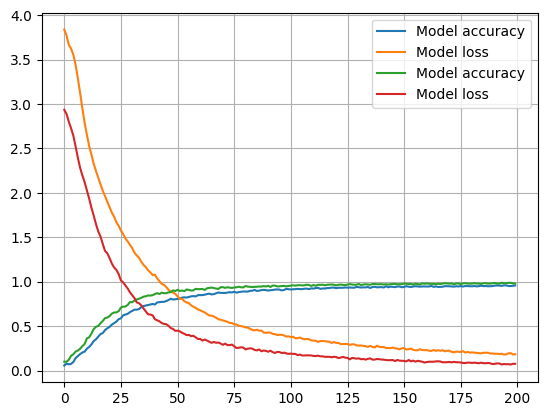

In [58]:
plt.plot(historyFR.history['accuracy'], label = "Model accuracy")
plt.plot(historyFR.history['loss'], label = "Model loss")
plt.plot(historyEN.history['accuracy'], label = "Model accuracy")
plt.plot(historyEN.history['loss'], label = "Model loss")
plt.legend()
plt.grid()

# Testing frenshi
Finally, let's chat with Frenshi a little bit about the administrative formalities in France for foreign students.

In [60]:
lang = input("Veuillez s'il vous plait selectionner une langue/Please select a preferred language: FR, EN ")
while True:
  texts_p = []
  if(lang == "FR"):
    prediction_input = input("Utilisateur: ")
  else :
    prediction_input = input("User : ")
  #Preprocessing the user's input
  prediction_input = [ltrs.lower() for ltrs in prediction_input if ltrs not in string.punctuation]
  prediction_input = ''.join(prediction_input)
  prediction_inputTmp = prediction_input
  texts_p.append(prediction_input)
  #Tokenizing the user's input
  if(lang == "FR"):
    prediction_input = tokenizerFR.texts_to_sequences(texts_p)
  else:
    prediction_input = tokenizerEN.texts_to_sequences(texts_p)
  prediction_input = np.array(prediction_input).reshape(-1)
  #Apply padding
  #Perform prediction on user's input
  if(lang == "FR"):
    prediction_input = pad_sequences([prediction_input], input_shapeFR)
    output = modelFR.predict(prediction_input)
  else:
    prediction_input = pad_sequences([prediction_input], input_shapeEN)
    output = modelEN.predict(prediction_input)
  output = output.argmax()
  #Convert model output back to text
  if(lang == "FR"):
    response_tag = labelEncFR.inverse_transform([output])[0]
    print("Frenshi: ", random.choice(responsesFR[response_tag]))
  else :
    response_tag = labelEncEN.inverse_transform([output])[0]
    print("Frenshi: ", random.choice(responsesEN[response_tag]))
  #print the best answer to the user's input
  if response_tag == "goodbyeDay FR" or response_tag == "goodbyeEvening FR" or response_tag == "goodbyeDay EN" or response_tag == "goodbyeEvening EN":
    break

Veuillez s'il vous plait selectionner une langue/Please select a preferred language: FR, EN EN
User : Hi!
1/1 [==============================] - 0s 496ms/step
Frenshi:  Welcome! I'm Frenshi! I'm here to help you with your administrative formalities in France. Administrative formalities can be a real headache, especially for foreign students arriving in a new country. But don't worry! I've got you covered! To get started, please select one of the following options:
Validate my visa, resident permit CAF or social security
User : resident permit
1/1 [==============================] - 0s 22ms/step
Frenshi:  The resident permit is a document that allows you to move around and cross the borders of the Schengen area. As a foreign student, you need to apply for a 'student' resident permit or 'researcher' resident permit if you have come to do a PhD thesis.
User : Supporting documents resident permit
1/1 [==============================] - 0s 24ms/step
Frenshi:  Here is the list of supporting do